In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import chi2_contingency
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [ ]:
# input files/dirs
ALL_TCGA = "../../data/tcga_data_annotated"
MUT_ANNOT = "../../data/combined_tcga_variants"
DRIVER_GENES = "../../data/TCGA_driver_genes"
HOTSPOTS = "../../data/datasets/cancer_hotspots_drivers/hotspots_v2"
HOTSPOTS_HG38 = "../../data/datasets/cancer_hotspots_drivers/hotspots_tcga_hg38.bed"
CANCER_ORGAN_MAP = "../../metadata/cancer_types_acronyms.tsv"
SAMPLE_SHEET = "../../TCGA_scripts/vcf_annot_pipeline/gdc_sample_sheet.2025-11-04.tsv"
SURVIVAL_DATA = "../../data/datasets/TCGA/TCGA_survival_outcome.csv"

# output files/dirs
TCGA_MUT_IN_DRIVERS = "../../data/TCGA_mutations_in_driver_genes.tsv"
TCGA_TMB = "../../data/TCGA_tmb.tsv"
RESULTS_DIR = "../../results/TCGA"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
# get driver genes by cancer type
driver_files = os.listdir(DRIVER_GENES)
driver_files = [f for f in driver_files if f.endswith(".tsv")]
driver_gene_set = set()
driver_gene_dict = {}
driver_gene_lengths = {}
driver_gene_strand = {}
for file in driver_files:
	cohort = file.split(".")[0]
	driver_df = pd.read_csv(os.path.join(DRIVER_GENES, file), sep="\t")
	# for each gene in driver_df, if it doesn't exist in driver_gene_set, add (gene, gene_length) to the set
	for index, row in driver_df.iterrows():
		driver_gene_lengths[row['gene']] = row['gene_length']
		driver_gene_strand[row['gene']] = row['strand']
	driver_genes = set(driver_df['gene'])
	for driver_gene in driver_genes:
		driver_gene_set.add((cohort, driver_gene))
	driver_gene_dict[cohort] = driver_genes

In [4]:
if os.path.exists(TCGA_MUT_IN_DRIVERS) and os.path.exists(TCGA_TMB):
    mut_df = pd.read_csv(TCGA_MUT_IN_DRIVERS, sep="\t")
    tmb_df = pd.read_csv(TCGA_TMB, sep="\t")
    print(mut_df.shape, mut_df["bcr_patient_barcode"].nunique(), tmb_df.shape)
else:
    mut_df = pd.DataFrame()
    tmb_df = []
    patient_files = os.listdir(MUT_ANNOT)
    for i, file in enumerate(patient_files):
        patient_id = file.split(".")[0]
        try:
            df = pd.read_csv(os.path.join(MUT_ANNOT, file), sep="\t")
        except Exception as e:
            if e.args[0] == "No columns to parse from file":
                tmb = {
                    "bcr_patient_barcode": patient_id,
                    "total_mutations": 0,
                }
                tmb_df.append(tmb)
            else:
                print(f"Error reading file for patient {patient_id}: {e}")
            continue
        tmb = {
            "bcr_patient_barcode": patient_id,
            "total_mutations": df.shape[0]
        }
        tmb_df.append(tmb)
        cancer_type = df["cancer"].iloc[0].split("-")[1]
        df = df[df["gene"].isin(driver_gene_dict[cancer_type])]
        mut_df = pd.concat([mut_df, df], axis=0)
        if (i + 1) % 1000 == 0:
            print(f"Processed {i+1} files...")
    tmb_df = pd.DataFrame(tmb_df)
    print(mut_df.shape, mut_df["bcr_patient_barcode"].nunique(), tmb_df.shape)
    mut_df.to_csv(TCGA_MUT_IN_DRIVERS, sep="\t", index=False)
    tmb_df.to_csv(TCGA_TMB, sep="\t", index=False)

(914877, 6) 8867 (8942, 2)


In [5]:
sample_data_df = pd.read_csv(SAMPLE_SHEET, sep="\t")
sample_data_df["bcr_patient_barcode"] = sample_data_df["Case ID"].str.split(", ").str[0]
sample_data_df = sample_data_df[["bcr_patient_barcode", "Project ID"]].drop_duplicates()
sample_data_df.rename(columns={"Project ID": "cancer"}, inplace=True)
print(tmb_df.shape)
tmb_df = tmb_df.merge(sample_data_df, on="bcr_patient_barcode", how="left")
tmb_df["total_mutations"] = tmb_df["total_mutations"] * 1e6 / (3.2 * 1e9) # mutations/Mb for 3.2 Gb genome size
tmb_df["TMB_group"] = pd.cut(tmb_df["total_mutations"], bins=[0, 5, 10, np.inf], labels=["Low (0-5/Mb)", "Medium (5-10/Mb)", "High (>=10/Mb)"])
print(tmb_df.shape)

(8942, 2)
(8942, 4)


In [6]:
cancers = list(tmb_df["cancer"].unique())
cancers.sort()
print(f"Found {len(cancers)} cancer types: {cancers}")

Found 32 cancer types: ['TCGA-ACC', 'TCGA-BLCA', 'TCGA-BRCA', 'TCGA-CESC', 'TCGA-CHOL', 'TCGA-COAD', 'TCGA-DLBC', 'TCGA-ESCA', 'TCGA-GBM', 'TCGA-HNSC', 'TCGA-KICH', 'TCGA-KIRC', 'TCGA-KIRP', 'TCGA-LGG', 'TCGA-LIHC', 'TCGA-LUAD', 'TCGA-LUSC', 'TCGA-MESO', 'TCGA-OV', 'TCGA-PAAD', 'TCGA-PCPG', 'TCGA-PRAD', 'TCGA-READ', 'TCGA-SARC', 'TCGA-SKCM', 'TCGA-STAD', 'TCGA-TGCT', 'TCGA-THCA', 'TCGA-THYM', 'TCGA-UCEC', 'TCGA-UCS', 'TCGA-UVM']


In [7]:
mut_df = pd.merge(mut_df, tmb_df, on=["bcr_patient_barcode", "cancer"], how="left")
print(mut_df.shape)

(914877, 8)


## Annotating Driver Mutations

In [8]:
mut_df["cancer"] = mut_df["cancer"].str.replace("-", "_")
tmb_df["cancer"] = tmb_df["cancer"].str.replace("-", "_")

In [9]:
cancer_organ_map = pd.read_csv(CANCER_ORGAN_MAP, sep="\t")
print(cancer_organ_map.shape)
cancer_organ_map = cancer_organ_map[cancer_organ_map["Projects"].str.contains("TCGA")]
print(cancer_organ_map.shape)
cancer_organ_map = cancer_organ_map[["Acronym", "Cancer type", "Organ", "Hotspot cohort"]]
cancer_organ_map["Acronym"] = "TCGA_" + cancer_organ_map["Acronym"]
cancer_organ_map = cancer_organ_map.drop_duplicates()
print(cancer_organ_map.shape)
cancer_organ_map.head()

(48, 5)
(33, 5)
(33, 4)


,Acronym,Cancer type,Organ,Hotspot cohort
0,TCGA_ACC,Adrenocortical carcinoma,Adrenal Gland,adrenalgland
1,TCGA_BLCA,Bladder Urothelial Carcinoma,Bladder,bladder
3,TCGA_BRCA,Breast invasive carcinoma,Breast,breast
5,TCGA_CESC,Cervical squamous cell carcinoma and endocervi...,Cervix,cervix
6,TCGA_CHOL,Cholangiocarcinoma,Biliary,biliarytract


In [10]:
organ_project = cancer_organ_map[["Hotspot cohort", "Acronym"]].drop_duplicates()
print(organ_project.shape)
organ_project["Hotspot cohort"] = organ_project["Hotspot cohort"].str.split(",")
organ_project = organ_project.explode("Hotspot cohort")
print(organ_project.shape)

print(f"{len(set(cancers) - set(organ_project['Acronym'].tolist()))} cancers not in cancer_organ_map:", set(cancers) - set(organ_project["Acronym"].tolist()))
print(f"{len(set(organ_project['Acronym'].tolist()) - set(cancers))} cancer_organ_map entries not in cancers:", set(organ_project["Acronym"].tolist()) - set(cancers))

organ_project_map_dict = dict(zip(organ_project["Acronym"], organ_project["Hotspot cohort"]))

(33, 2)
(34, 2)
32 cancers not in cancer_organ_map: {'TCGA-LUSC', 'TCGA-TGCT', 'TCGA-LUAD', 'TCGA-LGG', 'TCGA-CESC', 'TCGA-PRAD', 'TCGA-MESO', 'TCGA-KIRC', 'TCGA-THCA', 'TCGA-SKCM', 'TCGA-READ', 'TCGA-DLBC', 'TCGA-COAD', 'TCGA-BRCA', 'TCGA-GBM', 'TCGA-LIHC', 'TCGA-PCPG', 'TCGA-ACC', 'TCGA-PAAD', 'TCGA-SARC', 'TCGA-BLCA', 'TCGA-KIRP', 'TCGA-UCS', 'TCGA-THYM', 'TCGA-KICH', 'TCGA-ESCA', 'TCGA-HNSC', 'TCGA-UVM', 'TCGA-CHOL', 'TCGA-OV', 'TCGA-UCEC', 'TCGA-STAD'}
33 cancer_organ_map entries not in cancers: {'TCGA_COAD', 'TCGA_LAML', 'TCGA_LUAD', 'TCGA_LIHC', 'TCGA_UCEC', 'TCGA_UVM', 'TCGA_CESC', 'TCGA_ACC', 'TCGA_KIRP', 'TCGA_MESO', 'TCGA_BRCA', 'TCGA_DLBC', 'TCGA_THYM', 'TCGA_SKCM', 'TCGA_ESCA', 'TCGA_LUSC', 'TCGA_OV', 'TCGA_LGG', 'TCGA_SARC', 'TCGA_CHOL', 'TCGA_PRAD', 'TCGA_PCPG', 'TCGA_READ', 'TCGA_PAAD', 'TCGA_STAD', 'TCGA_THCA', 'TCGA_TGCT', 'TCGA_KICH', 'TCGA_KIRC', 'TCGA_UCS', 'TCGA_HNSC', 'TCGA_GBM', 'TCGA_BLCA'}


In [11]:
indel_hotspots = pd.read_csv(f"{HOTSPOTS}/INDEL-hotspots.tsv", sep="\t")
snv_hotspots = pd.read_csv(f"{HOTSPOTS}/SNV-hotspots.tsv", sep="\t")
drivers_hotspots = pd.concat([indel_hotspots, snv_hotspots])
drivers_hotspots = drivers_hotspots[["Hugo_Symbol", "Genomic_Position", "Codon_Change", "Organ_Types", "qvalue"]]
drivers_hotspots = drivers_hotspots[drivers_hotspots["qvalue"] < 0.05]
drivers_hotspots["Genomic_Position"] = drivers_hotspots["Genomic_Position"].str.split("|")
drivers_hotspots = drivers_hotspots.explode("Genomic_Position")
drivers_hotspots["Genomic_Position"] = drivers_hotspots["Genomic_Position"].str.split("_").str[0]
drivers_hotspots = drivers_hotspots[["Hugo_Symbol", "Genomic_Position", "Organ_Types"]]
drivers_hotspots.drop_duplicates(inplace=True)
drivers_hotspots["Organ_Types"] = drivers_hotspots["Organ_Types"].str.split("|")
drivers_hotspots = drivers_hotspots.explode("Organ_Types")
drivers_hotspots["Organ_Types"] = drivers_hotspots["Organ_Types"].str.split(":").str[0]
drivers_hotspots.drop_duplicates(inplace=True)
drivers_hotspots.dropna(inplace=True)
print(drivers_hotspots.shape)

(14809, 3)


In [12]:
hotspots_hg38 = pd.read_csv(HOTSPOTS_HG38, sep="\t", header=None)
hotspots_hg38["hg38_mutation"] = hotspots_hg38[0].astype(str) + ":" + hotspots_hg38[2].astype(str)
hotspots_hg38["hg38_mutation"] = hotspots_hg38["hg38_mutation"].apply(lambda x: x.replace("chr", ""))
hotspots_hg38["hg19_mutation"] = hotspots_hg38[3].apply(lambda x: x.split("-")[0].replace("chr", ""))
drivers_hotspots = drivers_hotspots.merge(hotspots_hg38[["hg19_mutation", "hg38_mutation"]], left_on="Genomic_Position", right_on="hg19_mutation", how="left")
drivers_hotspots.drop(columns=["Genomic_Position"], inplace=True)
drivers_hotspots.rename(columns={"hg38_mutation": "Genomic_Position"}, inplace=True)
print(drivers_hotspots.shape)

(14809, 4)


In [13]:
# driver hotspot data
hotspot_set = set(zip(drivers_hotspots['Organ_Types'], drivers_hotspots['Genomic_Position']))
print(f"Total hotspot entries: {len(hotspot_set)}")

Total hotspot entries: 14809


In [14]:
mut_df["hotspot_organ"] = mut_df["cancer"].map(organ_project_map_dict)
print(mut_df.shape, mut_df['cancer'].nunique())
mut_df.drop_duplicates(inplace=True)
print(mut_df.shape)
mut_df["mutation_pos"] = mut_df["mutation"].str.split(":").str[0] + ":" + mut_df["mutation"].str.split(":").str[1].str.split("-").str[0]
# hotspot annotation
mut_df['is_hotspot'] = mut_df.apply(
    lambda row: (row['hotspot_organ'], row['mutation_pos']) in hotspot_set, axis=1
)
mut_df['has_hotspot'] = mut_df.groupby(['bcr_patient_barcode', 'gene'])['is_hotspot'].transform('any')
print(mut_df.shape)

(914877, 9) 32
(914877, 9)
(914877, 12)


## Passenger density Analysis

In [15]:
# passenger mutation density
mut_df_passenger_density = mut_df.groupby(["bcr_patient_barcode", "gene"]).agg({
	"is_hotspot": lambda x: x.value_counts().get(False, 0),
    "has_hotspot": "first",
    "cancer": "first",
    "total_mutations": "first",
    "TMB_group": "first"
}).reset_index().rename(columns={"is_hotspot": "passenger_density"})
print(mut_df_passenger_density.shape)

(53816, 7)


In [16]:
patient_info = tmb_df.set_index("bcr_patient_barcode")[["cancer", "total_mutations", "TMB_group"]]
# Build all possible (patient, gene) pairs that should exist
rows = []
for patient, row in patient_info.iterrows():
    cohort = row["cancer"]
    tmb = row["total_mutations"]
    tmb_group = row["TMB_group"]
    cancer_type = cohort.split("_")[1]
    driver_genes = driver_gene_dict[cancer_type]
    for gene in driver_genes:
        rows.append((patient, gene, cohort, tmb_group, tmb))
full_df = pd.DataFrame(rows, columns=["bcr_patient_barcode", "gene", "cancer", "TMB_group", "total_mutations"])
print(full_df.shape)
merged = full_df.merge(
    mut_df_passenger_density[["bcr_patient_barcode", "gene", "has_hotspot", "passenger_density"]],
    on=["bcr_patient_barcode", "gene"],
    how="left",
)
merged["has_hotspot"] = merged["has_hotspot"].fillna(False)
merged["passenger_density"] = merged["passenger_density"].fillna(0)
passenger_density = merged[["bcr_patient_barcode", "gene", "cancer", "total_mutations", "has_hotspot", "passenger_density", "TMB_group"]]
print(passenger_density.shape)

(88372, 5)
(88372, 7)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/3339437243.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["has_hotspot"] = merged["has_hotspot"].fillna(False)


In [17]:
# add gene length, cna burden
passenger_density["gene_length"] = passenger_density["gene"].map(driver_gene_lengths)
print(passenger_density.shape)
passenger_density["adj_passenger_density"] = passenger_density.apply(
	lambda x: (x["passenger_density"] * 3.2e9 / (x["total_mutations"] * x["gene_length"])
			   if x["passenger_density"] > 0 else 0), axis=1
)

(88372, 8)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/3538903683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_density["gene_length"] = passenger_density["gene"].map(driver_gene_lengths)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/3538903683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_density["adj_passenger_density"] = passenger_density.apply(


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/1619311851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/1619311851.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/1619311851.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: Mann-Whitney-Wilcoxon test smaller, P_val:1.213e-146 U_stat=2.443e+08


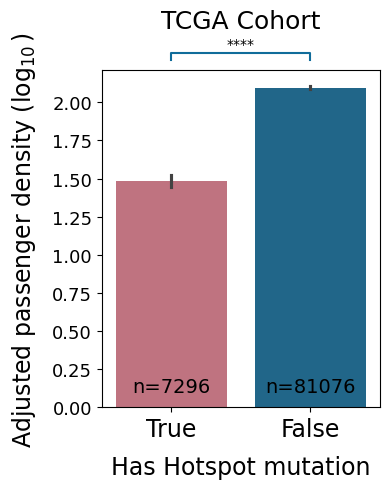

In [18]:
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))

plt.figure(figsize=(4, 5))
ax = sns.barplot(
    x="has_hotspot",
    y="passenger_density_log",
    data=passenger_density,
    order=[True, False],
    palette=cmap,
)

# show number of data points
for i, has_hotspot in enumerate([True, False]):
    n = passenger_density[passenger_density["has_hotspot"] == has_hotspot].shape[0]
    plt.text(i, 0.1, f"n={n}", ha='center', fontsize=14, color='black')
    
# get statistical significance annotations
annotator = Annotator(
    ax, 
    data=passenger_density, 
    x="has_hotspot",
    y="passenger_density_log", 
    pairs=[(True, False)],
    order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

plt.xlabel("Has Hotspot mutation", fontsize=17, labelpad=10)
plt.xticks(fontsize=17)
plt.yticks(fontsize=13)
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=17, labelpad=10)
plt.title("TCGA Cohort", fontsize=18, pad=30)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_hotspot_status.png", dpi=300)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/3527893425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/3527893425.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax1 = sns.boxplot(


[(('TCGA_ACC', True), ('TCGA_ACC', False)), (('TCGA_BLCA', True), ('TCGA_BLCA', False)), (('TCGA_BRCA', True), ('TCGA_BRCA', False)), (('TCGA_CESC', True), ('TCGA_CESC', False)), (('TCGA_CHOL', True), ('TCGA_CHOL', False)), (('TCGA_COAD', True), ('TCGA_COAD', False)), (('TCGA_DLBC', True), ('TCGA_DLBC', False)), (('TCGA_ESCA', True), ('TCGA_ESCA', False)), (('TCGA_GBM', True), ('TCGA_GBM', False)), (('TCGA_HNSC', True), ('TCGA_HNSC', False)), (('TCGA_KICH', True), ('TCGA_KICH', False)), (('TCGA_KIRC', True), ('TCGA_KIRC', False)), (('TCGA_KIRP', True), ('TCGA_KIRP', False)), (('TCGA_LGG', True), ('TCGA_LGG', False)), (('TCGA_LIHC', True), ('TCGA_LIHC', False)), (('TCGA_LUAD', True), ('TCGA_LUAD', False)), (('TCGA_LUSC', True), ('TCGA_LUSC', False)), (('TCGA_MESO', True), ('TCGA_MESO', False)), (('TCGA_OV', True), ('TCGA_OV', False)), (('TCGA_PAAD', True), ('TCGA_PAAD', False)), (('TCGA_PCPG', True), ('TCGA_PCPG', False)), (('TCGA_PRAD', True), ('TCGA_PRAD', False)), (('TCGA_READ', True

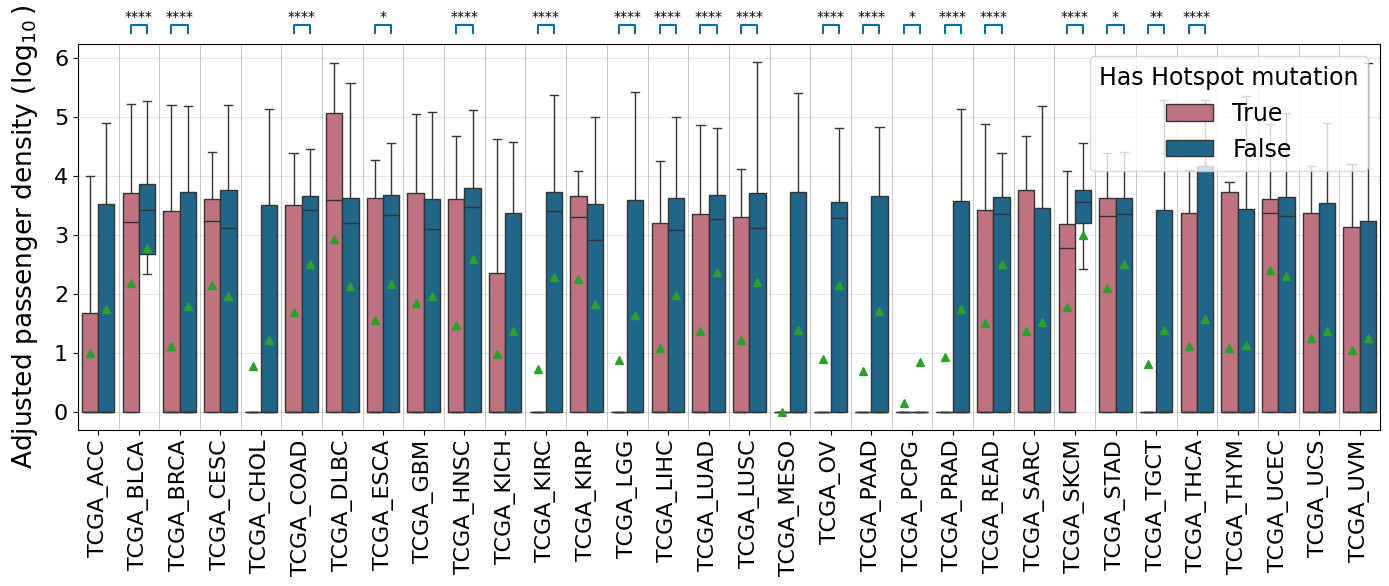

In [19]:
# distribution of passenger mutation density by cancer type
passenger_density["passenger_density_log"] = passenger_density["adj_passenger_density"].apply(lambda x: np.log10(x + 1))
cancers = passenger_density["cancer"].unique().tolist()
# cancers.remove("LYMP")
cancers.sort()
plt.figure(figsize=(14, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
ax1 = sns.boxplot(
    x="cancer",
    y="passenger_density_log",
    hue="has_hotspot",
    data=passenger_density,
    palette=cmap,
    order=cancers,
    hue_order=[True, False],
    showmeans=True,
    showfliers=False,
)
# add grid lines
ax1.grid(axis='y', alpha=0.3)
for i in range(len(cancers) - 1):
	ax1.axvline(i + 0.5, color='black', lw=0.5, alpha=0.3)

# get statistical significance annotations
box_pairs = []
for cancer in cancers:
    cancer_data = passenger_density[passenger_density["cancer"] == cancer]
    if len(cancer_data["has_hotspot"].unique().tolist()) == 2:
        box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax1, 
    data=passenger_density, 
    x="cancer", 
    y="passenger_density_log", 
    hue="has_hotspot",
    pairs=box_pairs,
    order=cancers,
    hue_order=[True, False]
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.configure(comparisons_correction="fdr_bh", verbose=2)
annotator.apply_test().annotate()

plt.xlabel("")
plt.ylabel(r"Adjusted passenger density ($\log_{10}$)", fontsize=19, labelpad=10)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.legend(title="Has Hotspot mutation", title_fontsize=17, fontsize=17, loc='upper right')
plt.savefig(f"{RESULTS_DIR}/passenger_density_by_cancer.png", dpi=300)

## Observed vs Expected

In [20]:
upper_limit = 10
passenger_counts = passenger_density[["has_hotspot", "passenger_density"]].copy()
passenger_counts = passenger_counts[passenger_counts["passenger_density"] <= upper_limit]
passenger_counts.head()

,has_hotspot,passenger_density
0,False,6.0
1,False,0.0
2,False,0.0
3,False,0.0
4,False,5.0


In [21]:
# chi-square test
observed = pd.crosstab(
    passenger_counts["has_hotspot"],
    passenger_counts["passenger_density"],
)
print(observed)
stat, p, dof, expected = chi2_contingency(observed)
print(f"p-value: {p}, stat: {stat}")
print(expected)

expected_df = pd.DataFrame(expected, columns=observed.columns, index=observed.index)
expected_df = expected_df.rename_axis(index=None, columns=None)
observed_df = pd.DataFrame(observed, columns=observed.columns, index=observed.index)
observed_df = observed_df.rename_axis(index=None, columns=None)

# get the difference between observed and expected for corresponding cells
residuals = observed_df - expected_df
residuals.head()

passenger_density   0.0    1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   \
has_hotspot                                                                 
False              34556  13975  6614  3841  2492  1917  1458  1181  1089   
True                4300   1246   451   254   167    93    57    56    47   

passenger_density  9.0   10.0  
has_hotspot                    
False               953   838  
True                 51    34  
p-value: 2.6406957291561207e-111, stat: 547.807221952964
[[35386.84265891 13862.03243029  6434.21977005  3729.38852914
   2421.59807057  1830.54235496  1379.73714814  1126.55765825
   1034.57518171   914.36045989   794.14573807]
 [ 3469.15734109  1358.96756971   630.78022995   365.61147086
    237.40192943   179.45764504   135.26285186   110.44234175
    101.42481829    89.63954011    77.85426193]]


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
False,-830.842659,112.96757,179.78023,111.611471,70.401929,86.457645,78.262852,54.442342,54.424818,38.63954,43.854262
True,830.842659,-112.96757,-179.78023,-111.611471,-70.401929,-86.457645,-78.262852,-54.442342,-54.424818,-38.63954,-43.854262


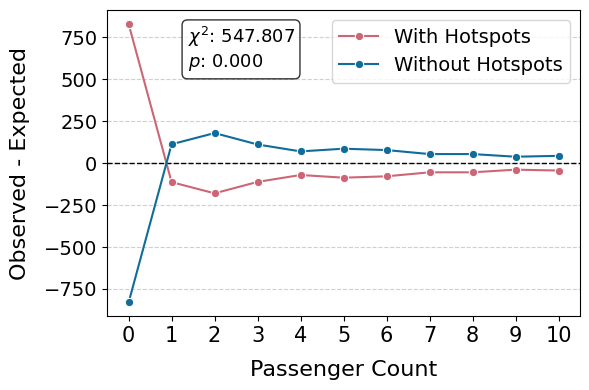

In [22]:
plt.figure(figsize=(6, 4))

# horizontal line at y=0
plt.axhline(0, color='black', lw=1, ls='--')

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[True],
	color=colors[0],
	label="With Hotspots",
	marker="o",
)

sns.lineplot(
	x=residuals.columns,
	y=residuals.loc[False],
	color=colors[1],
	label="Without Hotspots",
	marker="o",
)

# add p-value annotation
plt.annotate(
	rf"$\chi^2$: {stat:.3f}" + "\n" + rf"$p$: {p:.3f}", 
	xy=(0.17, 0.95), 
	xycoords='axes fraction', 
	fontsize=13, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
)

plt.xlabel("Passenger Count", fontsize=16, labelpad=10)
plt.xticks([i for i in range(0, upper_limit + 1)], fontsize=15)
plt.ylabel("Observed - Expected", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/passenger_count_observed_expected_difference.png", dpi=300)

## Overall Survival Analysis

In [23]:
survival_df = pd.read_csv(SURVIVAL_DATA)
survival_df = survival_df[["bcr_patient_barcode", "OS", "OS.time"]]
print(survival_df.shape)

(11160, 3)


In [24]:
def get_mut_status(row):
    if row["has_hotspot"]:
        return "Has Hotspot"
    else:
        if row["passenger_density"] > 0:
            return "Passengers only"
        else:
            return "No mutation"

In [25]:
patient_data = passenger_density[["bcr_patient_barcode", "gene", "cancer", "has_hotspot", "passenger_density", "adj_passenger_density", "TMB_group", "total_mutations"]]
patient_data["mutation_status"] = patient_data.apply(lambda x: get_mut_status(x), axis=1)
print(patient_data.shape)
patient_data.drop_duplicates(inplace=True)
print(patient_data.shape)
patient_data = patient_data.merge(survival_df, on="bcr_patient_barcode", how="left")
print(patient_data.shape)
patient_data.dropna(subset=["OS", "OS.time"], inplace=True)
print(patient_data.shape)

(88372, 9)
(88372, 9)
(88372, 11)
(86709, 11)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/134103416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data["mutation_status"] = patient_data.apply(lambda x: get_mut_status(x), axis=1)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_94002/134103416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data.drop_duplicates(inplace=True)


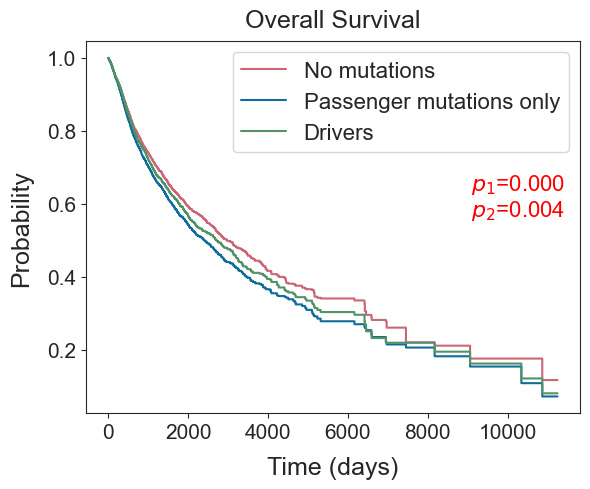

In [26]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267", "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(6, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = patient_data[patient_data["mutation_status"] == "No mutation"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers"
categories = ["Passengers only"]
group1 = patient_data[patient_data["mutation_status"].isin(categories)]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger mutations only')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.6, rf"$\it{{p}}_1$={p_value1:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color1)

# "no mutations" vs "drivers"
group2 = patient_data[patient_data["mutation_status"] == "Has Hotspot"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Drivers')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color3 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.53, rf"$\it{{p}}_2$={p_value2:.3f}", 
			transform=plt.gca().transAxes, fontsize=16, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=18)
plt.xlabel('Time (days)', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/overall_survival.png", dpi=300)

## Survival analysis by Passenger Burden

In [27]:
def get_quartile(row):
	if row["mutation_status"] == "Has Hotspot" or row["mutation_status"] == "No mutation":
		return row["mutation_status"]
	gene = row["gene"]
	passenger_density = row["passenger_density"]
	gene_quartiles = gene_data[gene_data["gene"] == gene]["quartiles"].values[0]
	if passenger_density <= gene_quartiles[1]:
		return "Low"
	else:
		return "High"

gene_data = patient_data[patient_data["mutation_status"] == "Passengers only"]
gene_data = gene_data[["gene", "passenger_density"]]
gene_data = gene_data.groupby("gene").agg({
	"passenger_density": lambda x: list(x)
}).reset_index()
gene_data["quartiles"] = gene_data["passenger_density"].apply(lambda x: np.percentile(x, [0, 25, 50, 75, 100]))
gene_data.head()

,gene,passenger_density,quartiles
0,AKT1,"[1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 2.0, 8.0]"
1,APC,"[4.0, 2.0, 3.0, 1.0, 68.0, 2.0, 3.0, 1.0, 22.0...","[1.0, 2.0, 3.0, 8.0, 151.0]"
2,AR,"[1.0, 14.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0,...","[1.0, 1.0, 1.0, 2.0, 27.0]"
3,ARID1A,"[1.0, 36.0, 1.0, 1.0, 2.0, 1.0, 7.0, 3.0, 2.0,...","[1.0, 1.0, 2.0, 7.0, 133.0]"
4,ARID2,"[1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, ...","[1.0, 1.0, 2.0, 2.0, 42.0]"


In [28]:
patient_data["passenger_density_group"] = patient_data.apply(lambda x: get_quartile(x), axis=1)
patient_data.value_counts("passenger_density_group")

passenger_density_group
No mutation    33746
High           27599
Low            18156
Has Hotspot     7208
Name: count, dtype: int64

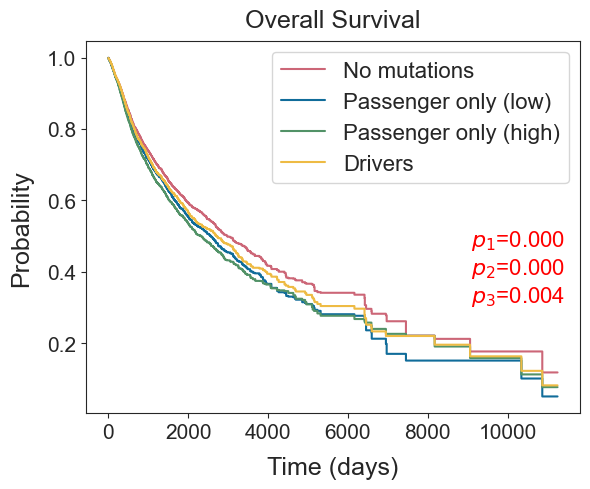

In [29]:
# custom color palette
colors = ["#CC6677", "#106C9A", "#529267",  "#eebb44"]
sns.palettes.color_palette(colors)
cmap = sns.color_palette(colors)

# KAPLAN-MEIER PLOTS
plt.figure(figsize=(6, 5))
sns.set_style("ticks")

# samples with no mutations in the gene
kmf_control = KaplanMeierFitter()
group0 = patient_data[patient_data["passenger_density_group"] == "No mutation"]
kmf_control_result = kmf_control.fit(group0["OS.time"], group0["OS"], label='No mutations')
kmf_control_result.plot_survival_function(color=cmap[0], ci_show=False)

# "no mutations" vs "passengers (low)"
group1 = patient_data[patient_data["passenger_density_group"] == "Low"]
if len(group1) > 0:
	kmf_exp1 = KaplanMeierFitter()
	kmf_exp1_result = kmf_exp1.fit(group1["OS.time"], group1["OS"], label='Passenger only (low)')
	kmf_exp1_result.plot_survival_function(color=cmap[1], ci_show=False)
	results1 = logrank_test(group0['OS.time'], group1['OS.time'], event_observed_A=group0['OS'], event_observed_B=group1['OS'])
	p_value1 = results1.p_value
	color1 = 'red' if p_value1 < 0.05 else 'black'
	plt.text(0.78, 0.45, rf"$\it{{p}}_1$={p_value1:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color1)

# "no mutations" vs "passengers (high)"
group2 = patient_data[patient_data["passenger_density_group"] == "High"]
if len(group2) > 0:
	kmf_exp2 = KaplanMeierFitter()
	kmf_exp2_result = kmf_exp2.fit(group2["OS.time"], group2["OS"], label='Passenger only (high)')
	kmf_exp2_result.plot_survival_function(color=cmap[2], ci_show=False)
	results2 = logrank_test(group0['OS.time'], group2['OS.time'], event_observed_A=group0['OS'], event_observed_B=group2['OS'])
	p_value2 = results2.p_value
	color2 = 'red' if p_value2 < 0.05 else 'black'
	plt.text(0.78, 0.375, rf"$\it{{p}}_2$={p_value2:.3f}",
		transform=plt.gca().transAxes, fontsize=16, color=color2)
         
# "no mutations" vs "drivers"
group3 = patient_data[patient_data["passenger_density_group"] == "Has Hotspot"]
if len(group3) > 0:
	kmf_exp3 = KaplanMeierFitter()
	kmf_exp3_result = kmf_exp3.fit(group3["OS.time"], group3["OS"], label='Drivers')
	kmf_exp3_result.plot_survival_function(color=cmap[3], ci_show=False)
	results3 = logrank_test(group0['OS.time'], group3['OS.time'], event_observed_A=group0['OS'], event_observed_B=group3['OS'])
	p_value3 = results3.p_value
	color3 = 'red' if p_value3 < 0.05 else 'black'
	plt.text(0.78, 0.3, rf"$\it{{p}}_3$={p_value3:.3f}", 
			transform=plt.gca().transAxes, fontsize=16, color=color3)

plt.ylabel('Probability', labelpad=10, fontsize=18)
plt.xlabel('Time (days)', labelpad=10, fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=16, loc='upper right')
plt.title("Overall Survival", fontsize=18, pad=10)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/overall_survival_by_passenger_density.png", dpi=300)